<a href="https://colab.research.google.com/github/santhiravuri/generative-ai-internship/blob/main/day9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving IMG.zip to IMG.zip
Epoch [1/25] Step [0/17] Loss_D: 1.3926 Loss_G: 2.6823
Epoch [2/25] Step [0/17] Loss_D: 0.0637 Loss_G: 10.6689
Epoch [3/25] Step [0/17] Loss_D: 0.2523 Loss_G: 11.2626
Epoch [4/25] Step [0/17] Loss_D: 0.3683 Loss_G: 15.8244
Epoch [5/25] Step [0/17] Loss_D: 0.0300 Loss_G: 9.5654
Epoch [6/25] Step [0/17] Loss_D: 0.2251 Loss_G: 5.2416
Epoch [7/25] Step [0/17] Loss_D: 0.5024 Loss_G: 2.4099
Epoch [8/25] Step [0/17] Loss_D: 0.6655 Loss_G: 4.9004
Epoch [9/25] Step [0/17] Loss_D: 2.0508 Loss_G: 6.6186
Epoch [10/25] Step [0/17] Loss_D: 0.6913 Loss_G: 2.2478
Epoch [11/25] Step [0/17] Loss_D: 0.8645 Loss_G: 4.6669
Epoch [12/25] Step [0/17] Loss_D: 0.6702 Loss_G: 2.7566
Epoch [13/25] Step [0/17] Loss_D: 0.7932 Loss_G: 3.2190
Epoch [14/25] Step [0/17] Loss_D: 0.8263 Loss_G: 2.2306
Epoch [15/25] Step [0/17] Loss_D: 0.5799 Loss_G: 3.0118
Epoch [16/25] Step [0/17] Loss_D: 0.8494 Loss_G: 4.0322
Epoch [17/25] Step [0/17] Loss_D: 0.6487 Loss_G: 2.6135
Epoch [18/25] Step [0/17] Lo

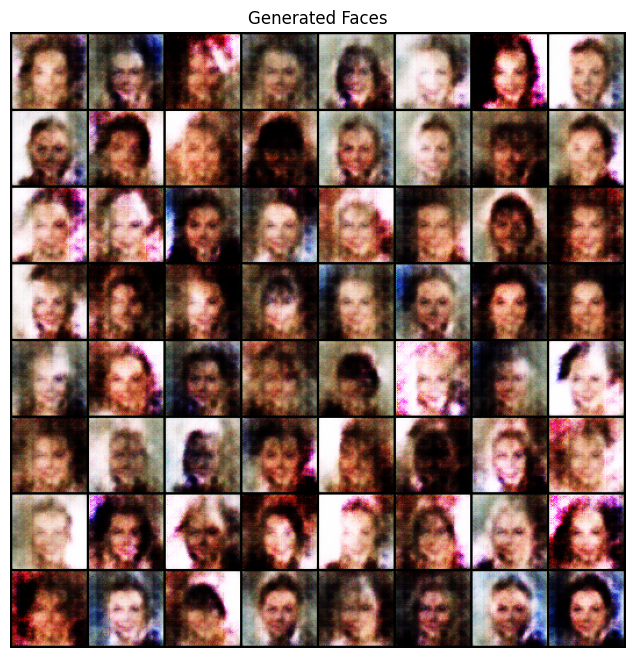

In [ ]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# === STEP 1: Upload ZIP File ===
from google.colab import files
uploaded = files.upload()

# === STEP 2: Extract ZIP ===
import zipfile
zip_filename = next(iter(uploaded))
extract_path = "/content/extracted_images"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# === STEP 3: Custom Dataset for Flat Image Folder ===
class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Look for images inside the 'IMG' subdirectory
        self.image_paths = glob.glob(os.path.join(root_dir, 'IMG', '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # dummy label for compatibility

# === STEP 4: Set Transform and Create DataLoader ===
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# The extract_path is still correct for the root directory where IMG is located
dataset = FlatImageDataset(root_dir=extract_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# === STEP 5: Define Generator and Discriminator ===
nz = 100
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# === STEP 6: Training Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# === STEP 7: Training Loop ===
epochs = 25
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Train Discriminator
        D.zero_grad()
        real_labels = torch.full((b_size,), 1., dtype=torch.float, device=device)
        fake_labels = torch.full((b_size,), 0., dtype=torch.float, device=device)

        output_real = D(real_images).view(-1)
        lossD_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G(noise)
        output_fake = D(fake_images.detach()).view(-1)
        lossD_fake = criterion(output_fake, fake_labels)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Train Generator
        G.zero_grad()
        output = D(fake_images).view(-1)
        lossG = criterion(output, real_labels)
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Step [{i}/{len(dataloader)}] "
                  f"Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f}")

# === STEP 8: Visualize Generated Images ===
with torch.no_grad():
    test_noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = G(test_noise).detach().cpu()
    grid = make_grid(fake_images, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Generated Faces")
    plt.show()